In [ ]:
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from PIL import Image

In [1]:
def load_data_from_coco(folder_path):
    with open(os.path.join(folder_path, "_annotations.coco.json"), 'r') as f:
        annotations = json.load(f)
    
    categories = {cat['id']: cat['name'] for cat in annotations['categories']}
    images = annotations['images']
    annotations_data = annotations['annotations']
    
    image_label_map = {}
    for ann in annotations_data:
        image_id = ann['image_id']
        label = categories[ann['category_id']]
        image_name = next(img['file_name'] for img in images if img['id'] == image_id)
        image_label_map[os.path.join(folder_path, image_name)] = label
    
    return image_label_map


To download dataset: https://www.kaggle.com/datasets/ammarnassanalhajali/bccd-coco

In [2]:
def prepare_dataset(base_path):
    datasets = {}
    for folder in ['train', 'valid', 'test']:
        folder_path = os.path.join(base_path, folder)
        datasets[folder] = load_data_from_coco(folder_path)
    return datasets

base_path = r"dataset_path"
datasets = prepare_dataset(base_path)


def load_images_and_labels(dataset):
    images, labels = [], []
    class_map = {}
    for i, (file_path, label) in enumerate(dataset.items()):
        img = Image.open(file_path).resize((128, 128)) 
        images.append(np.array(img) / 255.0)  
        if label not in class_map:
            class_map[label] = len(class_map)
        labels.append(class_map[label])
    return np.array(images), np.array(labels), class_map


train_images, train_labels, class_map = load_images_and_labels(datasets['train'])
valid_images, valid_labels, _ = load_images_and_labels(datasets['valid'])
test_images, test_labels, _ = load_images_and_labels(datasets['test'])

print("Number of training images:", len(train_images))
print("Number of validation images:", len(valid_images))
print("Number of testing images:", len(test_images))


Number of training images: 255
Number of validation images: 73
Number of testing images: 36


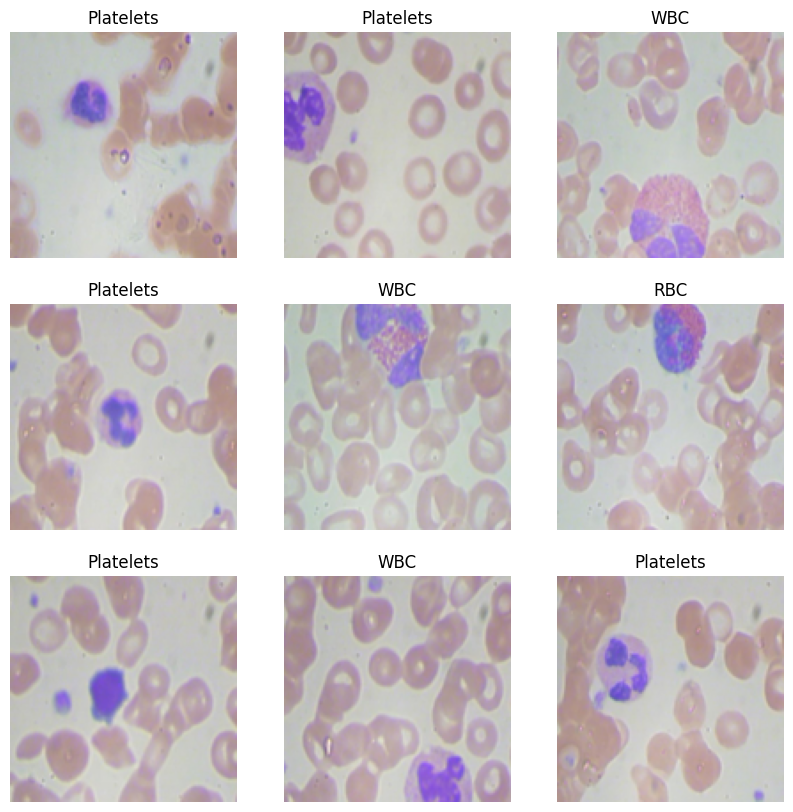

In [3]:
def display_samples(images, labels, class_map):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        idx = np.random.randint(len(images))
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[idx])
        plt.title(list(class_map.keys())[list(class_map.values()).index(labels[idx])])
        plt.axis("off")
    plt.show()

display_samples(train_images, train_labels, class_map)


In [4]:
def augment_data_on_the_fly(train_images, train_labels):
    datagen = ImageDataGenerator(
        rotation_range=20,
        horizontal_flip=True,
        rescale=1./255 
    )
    
    datagen_flow = datagen.flow(train_images, train_labels, batch_size=32)
    
    return datagen_flow


In [5]:
def build_and_train_model(X_train, y_train, X_valid, y_valid, class_map, epochs=10):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(len(class_map), activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=epochs)
    return model, history



Training without augmentation...


C:\Users\aasis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 339ms/step - accuracy: 0.3502 - loss: 3.7090 - val_accuracy: 0.5479 - val_loss: 0.9883
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 282ms/step - accuracy: 0.5465 - loss: 0.9995 - val_accuracy: 0.5479 - val_loss: 0.9790
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 282ms/step - accuracy: 0.4964 - loss: 1.0093 - val_accuracy: 0.5479 - val_loss: 0.9922
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 285ms/step - accuracy: 0.4944 - loss: 1.0226 - val_accuracy: 0.5479 - val_loss: 0.9858
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 277ms/step - accuracy: 0.5164 - loss: 1.0048 - val_accuracy: 0.5479 - val_loss: 0.9787
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 304ms/step - accuracy: 0.5655 - loss: 0.9467 - val_accuracy: 0.5205 - val_loss: 1.0214
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 267ms/step - accuracy: 0.5373 - loss: 0.9644 - val_accuracy: 0.4932 - val_loss: 1.0295
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 241ms/step - accuracy: 0.5554 - loss: 0.9443 - val_accuracy: 0.4932 - val_loss:

C:\Users\aasis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 276ms/step - accuracy: 0.4966 - loss: 1.0518 - val_accuracy: 0.5479 - val_loss: 1.1536
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 266ms/step - accuracy: 0.5063 - loss: 1.0399 - val_accuracy: 0.5479 - val_loss: 1.3163
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 270ms/step - accuracy: 0.5070 - loss: 1.0257 - val_accuracy: 0.5479 - val_loss: 1.4835
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 272ms/step - accuracy: 0.5226 - loss: 1.0112 - val_accuracy: 0.5479 - val_loss: 1.5661
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 267ms/step - accuracy: 0.4678 - loss: 1.0478 - val_accuracy: 0.5479 - val_loss: 1.4997
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/step - accuracy: 0.4766 - loss: 1.0452 - val_accuracy: 0.5479 - val_loss: 1.6321
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 279ms/step - accuracy: 0.5076 - loss: 1.0330 - val_accuracy: 0.5479 - val_loss: 1.6571
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 278ms/step - accuracy: 0.5420 - loss: 1.0153 - val_accuracy: 0.5479 - val_loss:

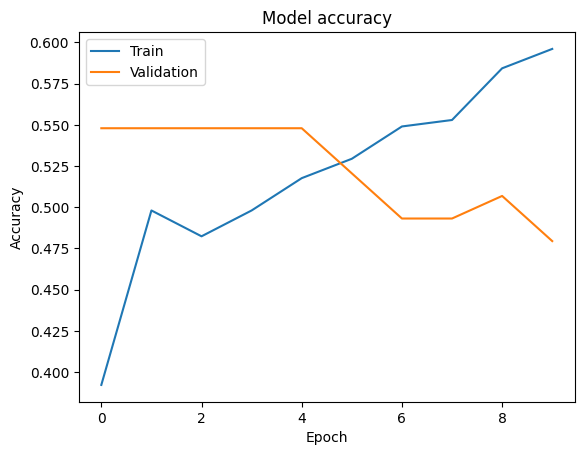

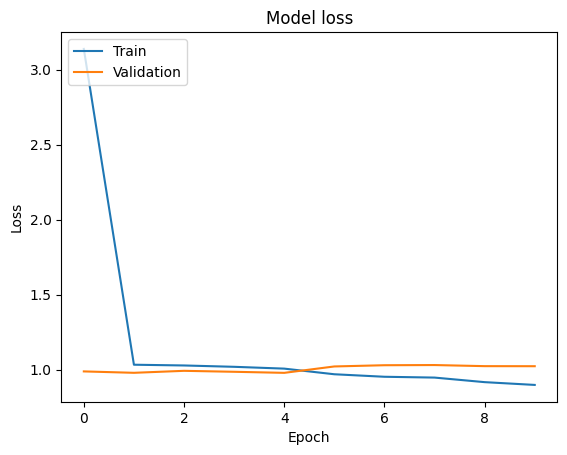


Plotting history for model with augmentation...


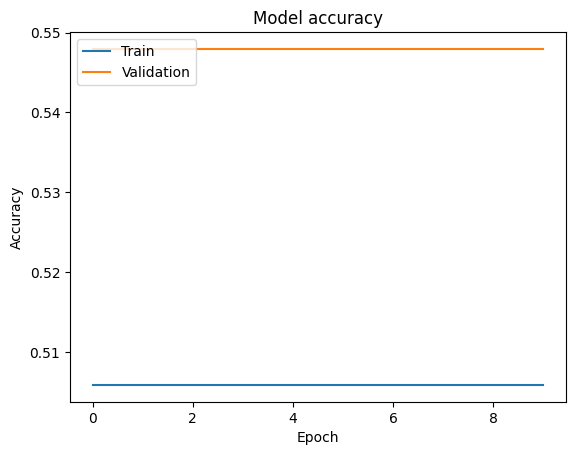

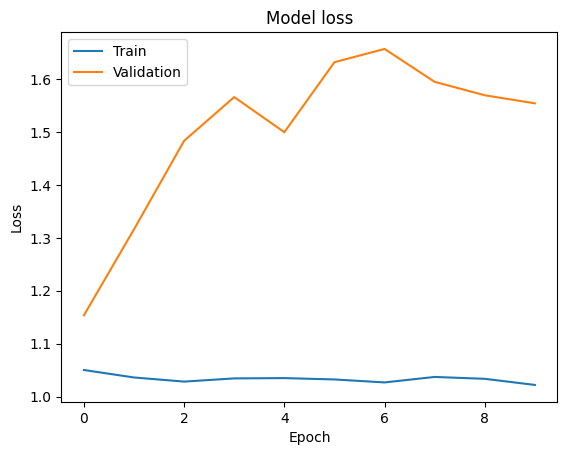

In [6]:
print("\nTraining without augmentation...")
model_no_aug, history_no_aug = build_and_train_model(train_images, train_labels, valid_images, valid_labels, class_map)

train_datagen_flow = augment_data_on_the_fly(train_images, train_labels)

print("\nTraining with augmentation...")
history_aug = model_no_aug.fit(train_datagen_flow, validation_data=(valid_images, valid_labels), epochs=10)

print("\nAccuracy without augmentation:", history_no_aug.history['val_accuracy'][-1])
print("Accuracy with augmentation:", history_aug.history['val_accuracy'][-1])

def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

print("\nPlotting history for model without augmentation...")
plot_history(history_no_aug)

print("\nPlotting history for model with augmentation...")
plot_history(history_aug)
